In [1]:
import math
import numpy as np
import torch
from torch import nn
from useTool import Accumulator, load_array
import ch3
from drawPlot import Animator

生成数据集

In [2]:
max_degree = 20 # 多项式的最⼤阶数
n_train, n_test = 100, 100 # 训练和测试数据集⼤⼩
true_w = np.zeros(max_degree) # 分配⼤量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype= torch.float32) for x in [true_w, features, poly_features, labels]]

In [4]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.1282],
         [0.8098]]),
 tensor([[1.0000e+00, 1.2815e-01, 8.2115e-03, 3.5078e-04, 1.1238e-05, 2.8804e-07,
          6.1522e-09, 1.1263e-10, 1.8042e-12, 2.5691e-14, 3.2924e-16, 3.8357e-18,
          4.0963e-20, 4.0380e-22, 3.6963e-24, 3.1580e-26, 2.5294e-28, 1.9067e-30,
          1.3575e-32, 9.1563e-35],
         [1.0000e+00, 8.0982e-01, 3.2790e-01, 8.8513e-02, 1.7920e-02, 2.9024e-03,
          3.9173e-04, 4.5319e-05, 4.5875e-06, 4.1278e-07, 3.3428e-08, 2.4609e-09,
          1.6608e-10, 1.0345e-11, 5.9842e-13, 3.2308e-14, 1.6352e-15, 7.7895e-17,
          3.5045e-18, 1.4937e-19]]),
 tensor([5.1645, 5.3086]))

训练和测试

In [5]:
def evaluate_loss(net, data_iter, loss): 
    """评估给定数据集上模型的损失"""
    metric = Accumulator(2) # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [6]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = load_array((train_features, train_labels.reshape(-1,1)), batch_size)
    test_iter = load_array((test_features, test_labels.reshape(-1,1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2],
    legend=['train', 'test'])
    for epoch in range(num_epochs):
        ch3.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), 
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正常)

weight: [[ 5.013944   1.2006354 -3.4278972  5.595823 ]]


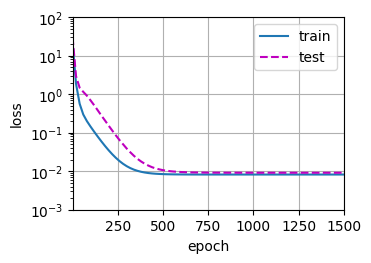

In [11]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4], 
      labels[:n_train], labels[n_train:], num_epochs=1500)

线性函数拟合(⽋拟合)

weight: [[3.1883416 3.7303743]]


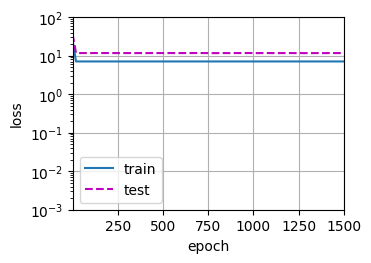

In [12]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2], 
      labels[:n_train], labels[n_train:], num_epochs=1500)

⾼阶多项式函数拟合(过拟合)

weight: [[ 5.003412    1.2476126  -3.3772204   5.2843075  -0.1594982   1.1369116
   0.23898649  0.18068814 -0.18124308  0.19660485  0.05119885  0.064674
  -0.17409922 -0.12931187 -0.02328334  0.21366966  0.19871496  0.20394032
  -0.04335381  0.15128188]]


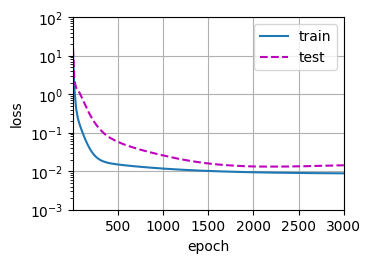

In [14]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :], 
      labels[:n_train], labels[n_train:], num_epochs=3000)